In [1]:
%load_ext autoreload
%autoreload 2

# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *


# Introduce the convolutional model

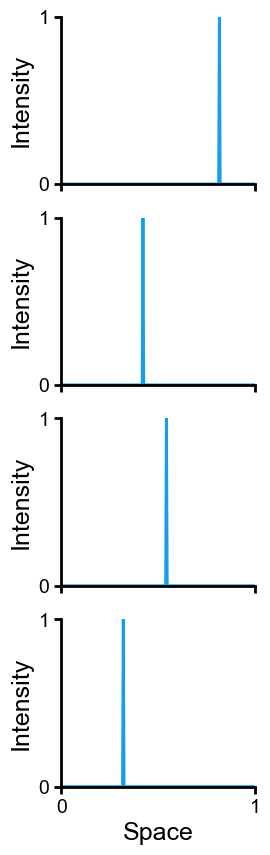

In [2]:
n_objects = 4
objects = np.array([sample_amplitude_object('delta') for i in range(n_objects)])
# plot all the objects
fig, ax = plt.subplots(n_objects, 1, figsize=(2.5, 2.5*n_objects), sharex=True, sharey=True)
for a, obj in zip(ax, objects):
    # fudge position so it matches better with the output signals below
    obj = np.roll(obj, 16)

    plot_in_spatial_coordinates(a, obj, sample_point_indices=None, plot_lim=1)
    a.set_xlabel(None)
ax[-1].set_xlabel('Space')

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'example_delta_objcts' + '.pdf', transparent=True)


In [3]:
# run a quick optimization to get a sinc-like psf

N_objects = 2000
noise_sigma = 0.01
num_nyquist_samples = 8

objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])
initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, max_epochs=1000)

initial loss -2.3728064549153434


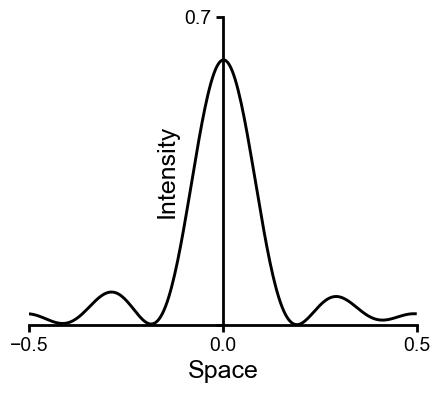

In [4]:
# signal = generate_random_1_over_f_signal(num_non_dc_in_bandlimit= 10)
delta_function = onp.zeros(UPSAMPLED_SIGNAL_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

kernel = signal_from_params(optimized_params, num_nyquist_samples=num_nyquist_samples)
# rotate the kernel so that it's centered
# kernel = np.roll(kernel, kernel.size // 2 - np.argmax(kernel))
conv_mat = make_convolutional_encoder(kernel, num_nyquist_samples=num_nyquist_samples)

# do the convolution
output_signal = conv_mat @ input_signal
# plot the output signal
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_spatial_coordinates(ax, output_signal, label='output signal', origin_at_center=True, center=True, plot_lim=
                            np.ceil(10 * np.max(kernel)) / 10, color='k')

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'example_psf' + '.pdf', transparent=True)


## Convolve objects with PSF to get output signals

### Shifting signal in the Fourier domain

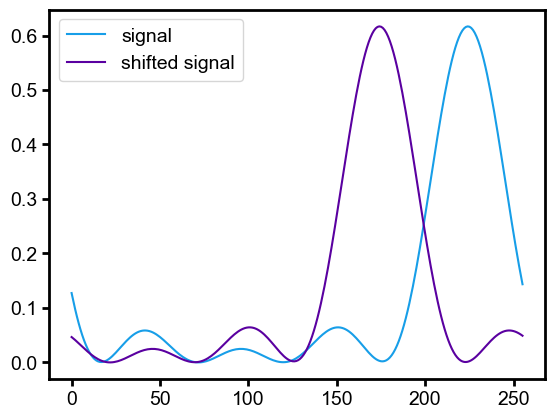

In [139]:
time_shift = 400

signal = initial_upsampled
fft_signal = np.fft.rfft(signal)

# Generate the frequency array
freqs = np.fft.rfftfreq(len(signal), d=num_nyquist_samples)

phase_shift = 2 * np.pi * freqs * time_shift
fft_shifted = fft_signal * np.exp(1j * phase_shift)

# Perform the inverse FFT
shifted_signal = np.fft.irfft(fft_shifted)

# plot signal and shifted signal
plt.plot(signal, label='signal')
plt.plot(shifted_signal, label='shifted signal')
plt.legend()



### Cycle consistency

In [240]:
# def us(x):
#     """
#     Take Nyquist samples of a signal and upsample it to the full interpolated signal
#     """
#     X = np.fft.rfft(x)

#     newshape = UPSAMPLED_SIGNAL_LENGTH // 2 + 1
#     # Copy positive frequency components (and Nyquist, if present)
#     nyq = num_nyquist_samples // 2 + 1  # Slice index that includes Nyquist if present
#     additional_zero_columns = newshape - nyq
#     Y = np.concatenate([X[:num_nyquist_samples // 2],
#                         0.5 * np.array([X[num_nyquist_samples // 2]]),
#                         np.zeros(additional_zero_columns, X.dtype)])
             
#     y = np.fft.irfft(Y, UPSAMPLED_SIGNAL_LENGTH)
#     y *= (float(UPSAMPLED_SIGNAL_LENGTH) / float(num_nyquist_samples))

#     return y


# def us2(x):
#     """
#     Take Nyquist samples of a signal and upsample it to the full interpolated signal
#     """
#     X = np.fft.rfft(x)
#     y = np.fft.irfft(np.concatenate([X, np.zeros(UPSAMPLED_SIGNAL_LENGTH // 2 - X.size + 1)] ))
#     y *= (float(UPSAMPLED_SIGNAL_LENGTH) / float(num_nyquist_samples))

#     return y

# def ds(y):
#     """
#     Take a fully interpolated signal and downsample it at the Nyquist rate
#     """

#     Y = np.fft.rfft(y)
#     # Retain only the frequency components up to the Nyquist rate
#     nyq = num_nyquist_samples // 2 + 1
#     Z = Y[:nyq]
#     if num_nyquist_samples % 2 == 0:
#         Z = np.concatenate([Z[:-1], np.array([Z[-1] * 2]) ]) # Correcting the Nyquist frequency component if even number of samples
    
#     z = np.fft.irfft(Z, num_nyquist_samples)
#     z *= (float(num_nyquist_samples) / float(UPSAMPLED_SIGNAL_LENGTH))

#     return z

# def ds(y):
#     """
#     Take a fully interpolated signal and downsample it at the Nyquist rate
#     """
#     samples = y[::UPSAMPLED_SIGNAL_LENGTH // num_nyquist_samples // 2]
#     return samples
    

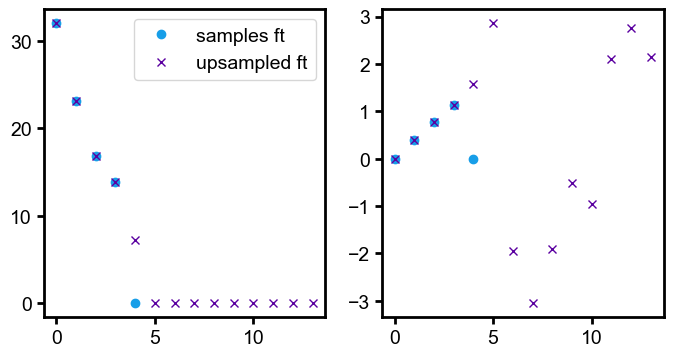

In [24]:
def ds(y):
    """
    Take a fully interpolated signal and downsample it at the Nyquist rate
    """
    samples = y[::UPSAMPLED_SIGNAL_LENGTH // num_nyquist_samples ]
    return samples


upsampled_ft = np.fft.rfft(problem_signal_upsampled)

samples = ds(problem_signal_upsampled)
samples_ft = np.fft.rfft(samples)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(np.abs(samples_ft) * 32, 'o', label='samples ft')
ax[0].plot(np.abs(upsampled_ft)[:14], 'x', label='upsampled ft')
ax[0].legend()

ax[1].plot(np.angle(samples_ft), 'o', label='samples ft')
ax[1].plot(np.angle(upsampled_ft)[:14], 'x', label='upsampled ft')




Downsampled to  8  samples
Downsampled to  16  samples
Downsampled to  10  samples


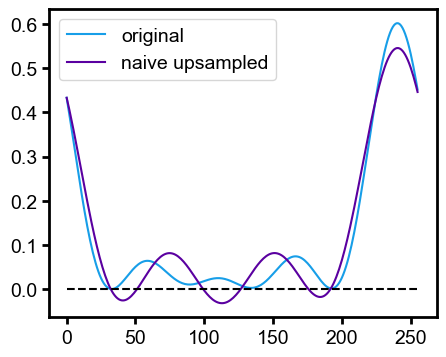

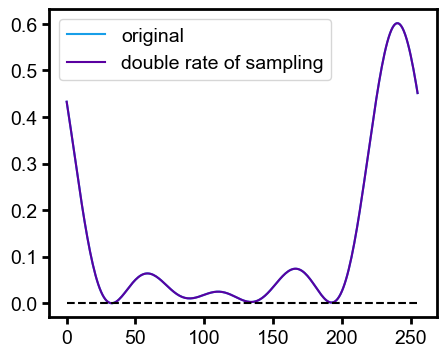

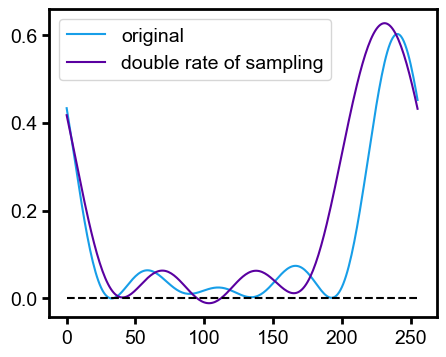

In [21]:
def signal_from_params(params, num_nyquist_samples=NUM_NYQUIST_SAMPLES):
    """
    Generate signal with unit energy from real and imaginary parts of the spectrum
    """
    real, imag, amplitude_logit = params
    if real.shape[-1] != imag.shape[-1] + 1:
        raise Exception('Real must be one bigger than imaginary (DC)')
    # construct full signal from trainable parameters
    full_spectrum = np.concatenate([np.array([0]), imag]) *1j + real
    signal = np.fft.irfft(full_spectrum, num_nyquist_samples)

    # get energy normalized positive signal
    # signal = bandlimited_nonnegative_signal(signal, num_nyquist_samples=num_nyquist_samples)
    # make amplitude always be between 0 and 1 using a sigmoid function
    # def sigmoid(x):
    #     return 1 / (1 + np.exp(-x))
    
    def tanh01(x):
        return (np.tanh(x) + 1) / 2
    
    def capped_relu(x):
        return np.clip(x, 0, 1)

    return signal * capped_relu(amplitude_logit)


def signal_from_params2(params, num_nyquist_samples=NUM_NYQUIST_SAMPLES):
    """
    Generate signal with unit energy from real and imaginary parts of the spectrum
    """
    real, imag, amplitude_logit = params
    if real.shape[-1] != imag.shape[-1] + 1:
        raise Exception('Real must be one bigger than imaginary (DC)')
    # construct full signal from trainable parameters
    full_spectrum = np.concatenate([np.array([0]), imag]) *1j + real
    signal = np.fft.irfft(full_spectrum, num_nyquist_samples * 2)

    # get energy normalized positive signal
    # signal = bandlimited_nonnegative_signal(signal, num_nyquist_samples=num_nyquist_samples * 2)
    # make amplitude always be between 0 and 1 using a sigmoid function
    # def sigmoid(x):
    #     return 1 / (1 + np.exp(-x))

    
    def capped_relu(x):
        return np.clip(x, 0, 1)

    return signal * capped_relu(amplitude_logit)


def us(x, num_nyquist_samples=NUM_NYQUIST_SAMPLES):
    """
    Take Nyquist samples of a signal and upsample it to the full interpolated signal
    """
    X = np.fft.rfft(x)

    newshape = UPSAMPLED_SIGNAL_LENGTH // 2 + 1
    # Copy positive frequency components (and Nyquist, if present)
    nyq = num_nyquist_samples // 2 + 1  # Slice index that includes Nyquist if present
    additional_zero_columns = newshape - nyq
    Y = np.concatenate([X[:num_nyquist_samples // 2],
                        0.5 * np.array([X[num_nyquist_samples // 2]]),
                        np.zeros(additional_zero_columns, X.dtype)])
             
    y = np.fft.irfft(Y, UPSAMPLED_SIGNAL_LENGTH)
    y *= (float(UPSAMPLED_SIGNAL_LENGTH) / float(num_nyquist_samples))

    return y


def ds(y, num_nyquist_samples=NUM_NYQUIST_SAMPLES):
    """
    Take a fully interpolated signal and downsample it at the Nyquist rate
    """
    samples = y[::UPSAMPLED_SIGNAL_LENGTH // num_nyquist_samples]
    return samples
    
# try to figure out how to sample an reonstruct the problematic signal

# naiive approach
downsampled = ds(problem_signal_upsampled, num_nyquist_samples=num_nyquist_samples)
print('Downsampled to ', len(downsampled), ' samples')
upsampled_naive = us(downsampled, num_nyquist_samples=num_nyquist_samples)

# plot the naive upsampled signal
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(problem_signal_upsampled, label='original')
ax.plot(upsampled_naive, label='naive upsampled')
ax.hlines(0, 0, len(upsampled_naive), linestyle='--', color='k')
ax.legend()

##### Try sampling at twice the rate
downsampled = ds(problem_signal_upsampled, num_nyquist_samples=num_nyquist_samples * 2)
print('Downsampled to ', len(downsampled), ' samples')
upsampled_doubled = us(downsampled, num_nyquist_samples=num_nyquist_samples * 2)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(problem_signal_upsampled, label='original')
ax.plot(upsampled_doubled, label='double rate of sampling')   
ax.hlines(0, 0, len(upsampled_doubled), linestyle='--', color='k')
ax.legend()



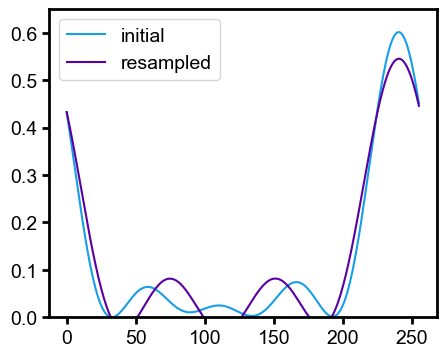

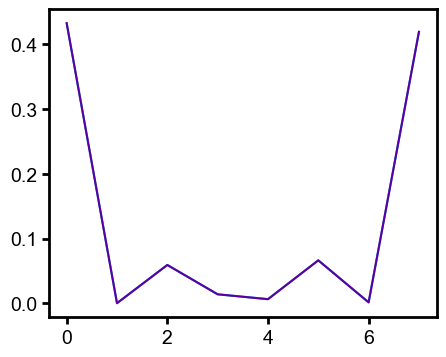

In [13]:
kernel_sampled = signal_from_params(optimized_params, num_nyquist_samples=num_nyquist_samples)

# conv_mat = make_convolutional_encoder(kernel_sampled, num_nyquist_samples=num_nyquist_samples)
# initial_upsampled = np.roll(conv_mat[62], 0)

initial_upsampled = upsample(kernel_sampled, num_nyquist_samples=num_nyquist_samples)
initial_upsampled = np.roll(initial_upsampled, 16)


initial_samples = downsample(initial_upsampled,  num_nyquist_samples=num_nyquist_samples)


upsampled = upsample(initial_samples, num_nyquist_samples=num_nyquist_samples)
upsampled_samples = downsample(upsampled, num_nyquist_samples=num_nyquist_samples)


# plot upsampled versions
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(initial_upsampled, label='initial')
ax.plot(upsampled, label='resampled')
ax.set_ylim(0, 0.65)
ax.legend()


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(initial_samples)
ax.plot(upsampled_samples)



problem_signal_upsampled = initial_upsampled

In [7]:
sample_point_indices = (3,4)


# convolve the objects
output_signals = conv_forward_model(optimized_params, objects, align_center=False, num_nyquist_samples=num_nyquist_samples, nyquist_sample_output=True)
print(upsample(output_signals, num_nyquist_samples=num_nyquist_samples).min())

output_signals_upsampled = conv_forward_model(optimized_params, objects, align_center=False, num_nyquist_samples=num_nyquist_samples, nyquist_sample_output=False)
print(output_signals_upsampled.min())


# fig, ax = plt.subplots(n_objects, 2, figsize=(5, 2.5*n_objects), sharex=True, sharey=False)

# for a, sig in zip(ax, output_signals):
#     # display_signal = upsample_signal(sig, num_nyquist_samples=num_nyquist_samples)
#     # fudge factor to make the alignment look better
#     # display_signal = np.roll(display_signal, -16)
#     plot_in_spatial_coordinates(a[0], sig, sample_point_indices=sample_point_indices, plot_lim=1, show_samples=True, num_nyquist_samples=num_nyquist_samples)
#     a[0].set_xlabel(None)

#     plot_in_intensity_coordinates(a[1], sig, sample_point_indices=sample_point_indices, plot_lim=1, markersize=48)
#     a[1].set_xlabel(None)

# ax[-1, 0].set_xlabel('Space')
# ax[-1, 1].set_xlabel('Intensity at x1')

# fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'example_output_signals' + '.pdf', transparent=True)


-0.035843419452826
6.938893903907228e-18


# Optimize to the target points

In [7]:
# num_nyquist_samples = NUM_NYQUIST_SAMPLES
num_nyquist_samples = 8

sampling_indices = (0, 1)
use_sampling_indices = True
num_grid_points = 10
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
object = delta_function

target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=num_grid_points,
                                                         num_nyquist_samples=num_nyquist_samples, randomize_non_sampling_indices=True)
optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, object,
                                                                    sampling_indices=sampling_indices if use_sampling_indices else None,
                                                                    verbose=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices, color=get_color_cycle()[2])
ax.legend()
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'optimizing_to_different_target_grid_sample_indices_{use_sampling_indices}' + '.pdf', transparent=True)


55it [00:04, 12.02it/s]
  0%|          | 0/55 [00:00<?, ?it/s]

initial loss 0.050423637


  0%|          | 0/55 [00:13<?, ?it/s]

KeyboardInterrupt: 

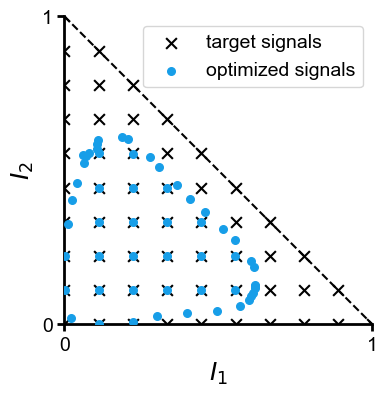

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x', markersize=60,
                               sample_point_indices=sampling_indices, color='k')
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)

ax.set(xticks=[0, 1], yticks=[0, 1])
ax.legend()
fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + f'optimizing_to_different_target_grid_sample_indices_{use_sampling_indices}' + '.pdf', transparent=True)


In [3]:
from signal_utils_1D import *

sampling_indices = (0, 1)
num_nyquist_samples = NUM_NYQUIST_SAMPLES
num_nyquist_samples = 8

sampling_indices = (0, 1)
num_grid_points = 4
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
object = delta_function


# indices = np.arange(10)
indices = onp.random.choice(np.arange(target_signals.shape[0]), size=6, replace=False)


# make a 2x6 grid with spatial plots on top and intensity plots on bottom
fig, ax = plt.subplots(len(indices), 2, figsize=(6, len(indices)*2.5), sharex='col')
for i, (ax1, ax2) in enumerate(zip(ax[:, 0], ax[:, 1])):
    output_signal = output_signals[indices[i]]
    target_signal = target_signals[indices[i]]

    plot_in_spatial_coordinates(ax1, output_signal, label='optimized signals', sample_point_indices=sampling_indices,
                                color_samples=True, show_samples=True, xlabel=None)
    plot_in_spatial_coordinates(ax1, target_signal, label='target signals', marker='x', color_samples=True,
                                color=get_color_cycle()[2],
                                sample_point_indices=sampling_indices, show_samples=True, xlabel=None)
    ax1.set(ylim=(-0.1, 1.1), yticks=[0, 1], xticks=[0, 1])
    ax1.spines['bottom'].set_position(('data', 0))

    plot_in_intensity_coordinates(ax2, output_signal, label='optimized signals', sample_point_indices=sampling_indices, markersize=60)
    plot_in_intensity_coordinates(ax2, target_signal, label='target signals', marker='x', color=get_color_cycle()[2],
                                   sample_point_indices=sampling_indices, markersize=60)
    ax2.set(yticks=[0, 1], xticks=[0, 1])

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'optimizing_to_different_targets' + '.pdf', transparent=True)


NameError: name 'target_signals' is not defined